<br/>

$$ \huge{\underline{\textbf{ Playing Atari Games with Deep RL }}} $$

$$ \large{\textbf{MountainCar + DQN + Memory Reply}} $$

<br/>



In [212]:
def q_learning(env, ep, gamma, eps_decay, eps_target, batch_size, q_hat, mem, callback=None, trace=None):
    """Episodic Semi-Gradient Sarsa
    
    Params:
        env - environment
        ep - number of episodes to run
        gamma - discount factor [0..1]
        eps - epsilon-greedy param
        q_hat      - function approximator, already initialised, with methods:
                     eval(state, action) -> float
                     train(state, target) -> None
    """
    def policy(st, q_hat, eps):
        if np.random.rand() > eps:
            q_values = q_hat.eval([st])
            return argmax_rand(q_values)
        else:
            return np.random.choice(env.act_space)
    
    if eps_decay is not None:
        eps = 1
        eps_delta = (1-eps_target) / eps_decay
    else:
        eps = eps_target
    
    for e_ in range(ep):
        
        S = env.reset()
        
        for t_ in range(10**100):
            
            A = policy(S, q_hat, eps)
            
            S_, R, done = env.step(A)
            
            mem.append(S, A, R, S_, done)
            
            if callback is not None:
                callback(e_, t_, S, A, R, done, eps, q_hat, mem, trace)
            
            # new
            states, actions, rewards, n_states, dones, _ = mem.get_batch(batch_size)
            targets = q_hat.eval(n_states)
            targets[dones] = 0   # value of terminal states is zero
            targets = targets[range(len(targets)), actions]
            
            #if True in dones:
            #    pdb.set_trace()
            
            # q_hat.train(states, actions, targets)
            # ---
            
            
            
            # old train
            if done:
                target = R
            else:
                max_q = np.max(q_hat.eval([S_]))
                target = R + gamma * max_q
            q_hat.train([S], [A], [target])
            # ---
            
            if done:
                break
                
            S = S_
            
            if eps > eps_target:
                eps -= eps_delta
                if eps < eps_target:
                    eps = eps_target

In [171]:
def test_car(env, ep, q_hat, callback=None, trace=None):

    def policy(st, q_hat):
        q_values = q_hat.eval([st])
        return argmax_rand(q_values)
    
    for e_ in range(ep):
        
        S = env.reset()
        
        
        for t_ in range(1000):       
        
            A = policy(S, q_hat)
            S_, R, done = env.step(A)
            
            if callback is not None:
                if t_ == 999:  done=True
                callback(e_, t_, S, A, R, done, 0, q_hat, mem, trace)
            
            if done:
                break
                
            S = S_

Tile Coding - see [chapter 9.5](0905b_LM_Agg_Tile.ipynb) for introduction

Helper functions

In [17]:
def argmax_rand(arr):
    # break ties randomly, np.argmax() always picks first max
    return np.random.choice(np.flatnonzero(arr == np.max(arr)))

In [10]:
def running_mean(x, n):
    res = []
    for i in range(len(x)):
#         print('i', i)
#         print('x[max(i-n+1, 0): i+1]', x[max(i-n+1, 0): i+1])
#         print('min(i+1, n)', min(i+1, n))
        
        res.append( sum(x[max(i-n+1, 0): i+1])   /   min(i+1, n) )
        
#         print('res', res)
        
#         print('--')
        
    return res

---

In [140]:
mem = Memory(1, (2,), float)

In [142]:
mem.append(St=[1, 1], At=1, Rt_1=1, St_1=[1,1], done_1=False )

In [144]:
mem.append(St=[2, 2], At=1, Rt_1=1, St_1=[1,1], done_1=False )

In [146]:
mem.append(St=[3, 3], At=1, Rt_1=1, St_1=[1,1], done_1=False )

In [148]:
mem.get_batch(1)

(array([[3., 3.]]),
 array([1]),
 array([1.]),
 array([[1., 1.]]),
 array([False]),
 array([0]))

In [149]:
mem._print_all()


_hist_St
[[3. 3.]]

_hist_At
[1]

_hist_Rt_1
[1.]

_hist_St_1
[[1. 1.]]

_hist_done_1
[False]


# Experiment Setup

Imports (source file: [tiles3.py](tiles3.py), [helpers_1001.py](helpers_1001.py))

In [11]:
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib.colors import ListedColormap
from collections import OrderedDict
from mountain_car import MountainCarEnv
import tiles3           # by Richard Sutton, http://incompleteideas.net/tiles/tiles3.html

Environment

In [12]:
env = MountainCarEnv()

Create function approximator and solve

# Run Q-Learn Experiment

We will need callback to capture q-value array for whole state-action space at specified episodes.

In [13]:
import pdb

In [66]:
class EpisodeLog():
    def __init__(self, episode_nb):
        self.episode_nb = episode_nb
        self.total_tstep_finish = 0
        self.q_values = None
        self.states = []
        self.actions = []
        self.rewards = []  # t+1
        self.dones = []    # t+1
        
class Trace():
    def __init__(self):
        self.total_tstep = 0
        self.episodes = []
        self.epsilons = []

In [179]:
def callback(episode, tstep, st, act, rew_, done_, eps, model, memory, trace):
    """Called from gradient_MC after every episode.
    
    Params:
        episode [int] - episode number
        tstep [int]   - timestep within episode
        model [obj]   - function approximator
        trace [list]  - list to write results to"""
    
            
    if tstep == 0:
        trace.episodes.append(EpisodeLog(episode))
    
    trace.episodes[-1].total_tstep_finish = trace.total_tstep
    trace.episodes[-1].states.append(st)
    trace.episodes[-1].actions.append(act)
    trace.episodes[-1].rewards.append(rew_)
    trace.episodes[-1].dones.append(done_)
    trace.epsilons.append(eps)
    
    if done_:
        q_arr = eval_state_action_space(model, env)
        trace.episodes[-1].q_values = q_arr
    
    if episode % 10 == 0 and tstep == 0:    
        print('.', end='')
        
    trace.total_tstep += 1

---

In [68]:
q_trace = Trace()
q_hat = TileCodingFuncApprox(env.state_low, env.state_high, env.act_space,
                             learn_rate=0.1, num_tilings=8, init_val=0)
mem = Memory(max_len=10000, state_shape=(2,), state_dtype=float)
q_learning(env, ep=100, gamma=1.0, eps_decay=40000, eps_target=0.1,
           q_hat=q_hat, mem=mem, callback=callback, trace=q_trace)

0


In [71]:
# Continue learning
q_learning(env, ep=20, gamma=1.0, eps_decay=None, eps_target=0.15,
           q_hat=q_hat, mem=mem, callback=callback, trace=q_trace)

0


In [ ]:
# Test car
test_car(env, ep=20, q_hat=q_hat, callback=callback, trace=q_trace)

Plot

In [103]:
def experiment(ep, eps_decay, eps_target):
    q_trace = Trace()
    q_hat = TileCodingFuncApprox(env.state_low, env.state_high, env.act_space,
                                 learn_rate=0.1, num_tilings=8, init_val=0)
    mem = Memory(max_len=10000, state_shape=(2,), state_dtype=float)
    q_learning(env, ep=ep, gamma=1.0, eps_decay=eps_decay, eps_target=eps_target,
               q_hat=q_hat, mem=mem, callback=callback, trace=q_trace)
    
    test_car(env, ep=20, q_hat=q_hat, callback=callback, trace=q_trace)
    print()
    return q_trace

In [93]:
def take_rew_eps(trace):
    rewards = [sum(trace.episodes[i].rewards) for i in range(len(trace.episodes))]
    episodes = [trace.episodes[i].total_tstep_finish for i in range(len(trace.episodes))]
    return episodes, rewards

In [101]:
q_trace_1 = experiment(ep=100, eps_decay=40000, eps_target=0.1)
q_trace_2 = experiment(ep=100, eps_decay=40000, eps_target=0.1)
q_trace_3 = experiment(ep=100, eps_decay=40000, eps_target=0.1)
q_trace_4 = experiment(ep=100, eps_decay=40000, eps_target=0.1)
q_trace_5 = experiment(ep=100, eps_decay=40000, eps_target=0.1)
q_traces = [q_trace_1, q_trace_2, q_trace_3, q_trace_4, q_trace_5]
q_colors = ['blue'] * len(q_traces)

................................................

In [213]:
def experiment_2(ep, eps_decay, eps_target):
    q_trace = Trace()
    q_hat = TileCodingFuncApprox(env.state_low, env.state_high, env.act_space,
                                 learn_rate=0.1, num_tilings=8, init_val=0)
    mem = Memory(max_len=1, state_shape=(2,), state_dtype=float)
    q_learning(env, ep=ep, gamma=1.0, eps_decay=eps_decay, eps_target=eps_target, batch_size=1,
               q_hat=q_hat, mem=mem, callback=callback, trace=q_trace)
    
    test_car(env, ep=20, q_hat=q_hat, callback=callback, trace=q_trace)
    print()
    return q_trace

In [216]:
d_trace_1 = experiment_2(ep=100, eps_decay=None, eps_target=0.01)

............


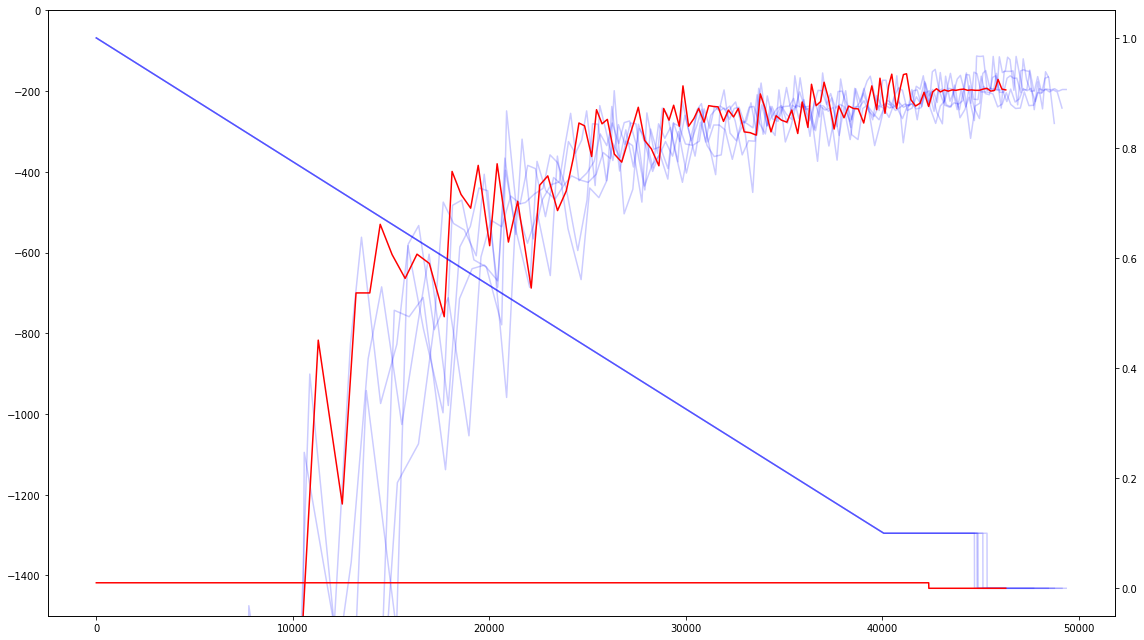

In [217]:

fig = plt.figure(figsize=[16,9])
ax = fig.add_subplot(111)
ax.set_ylim([-1500, 0])
ax2 = ax.twinx()

for trace, color in  zip(q_traces, q_colors):
    episodes, rewards = take_rew_eps(trace)
    ax.plot(episodes, rewards, color=color, alpha=0.2)
    ax2.plot(trace.epsilons, color=color, alpha=0.2)

for trace in [d_trace_1]:
    episodes, rewards = take_rew_eps(trace)
    ax.plot(episodes, rewards, color='red', alpha=1)
    ax2.plot(trace.epsilons, color='red', alpha=1)
    

plt.tight_layout()
plt.show()

# Run Sarsa Experiment

---

# Plot results

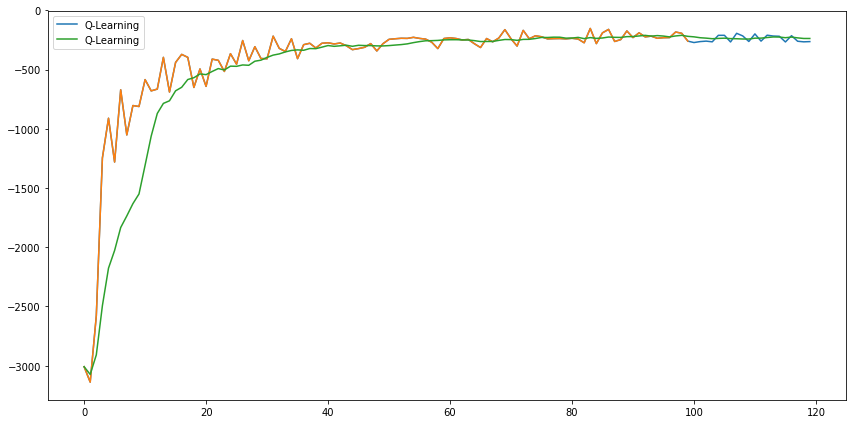

In [41]:
fig = plt.figure(figsize=[12,6])
ax = fig.add_subplot(111)
rewards_q_learning_train = [sum(q_trace.episodes[i].rewards) for i in range(len(q_trace.episodes))]
rewards_q_learning_test = [sum(qt_trace.episodes[i].rewards) for i in range(len(qt_trace.episodes))]
ax.plot(rewards_q_learning_train + rewards_q_learning_test, label='Q-Learning')
ax.plot(rewards_q_learning_train)
ax.plot(running_mean(rewards_q_learning_train + rewards_q_learning_test, 10), label='Q-Learning')
#ax.set_ylim([-250, 0])
ax.legend()
plt.tight_layout()
plt.show()

In [319]:
for episode_log in qt_trace.episodes:
    plot_mountain_car(env, episode_log )

In [318]:
for episode_log in q_trace.episodes[::100]:
    plot_mountain_car(env, episode_log )

In [198]:
# for episode_log in s_trace.episodes[-20:]:
#     plot_mountain_car(q_arr = episode_log.q_values,
#                       states = episode_log.states,
#                       actions = episode_log.actions,
#                       env = env,
#                       episode = episode_log.episode_nb)

---

# Appendix - function definitions

In [1]:
def plot_mountain_car(env, episode_log):
    
    q_arr = episode_log.q_values
    states = episode_log.states
    actions = episode_log.actions
    episode = episode_log.episode_nb

    
    fig = plt.figure(figsize=[12,4])

    if q_arr is not None:
        ax = fig.add_subplot(131, projection='3d')
        plot_q_max_3d(q_arr, env, title='Episode '+str(episode), 
                      labels=['Position', 'Velocity', ''], alpha=.4, axis=ax)

    ax = fig.add_subplot(132)
    plot_trajectory(states, actions, env, labels=['Position', 'Velocity'], axis=ax)
    
    ax = fig.add_subplot(133)
    plot_policy(q_arr, env, labels=['Position', 'Velocity'],
                colors=['red', 'blue','green'], collab=['left', 'idle', 'right'], axis=ax)

    plt.tight_layout()
    plt.show()

In [2]:
def plot_trajectory(states, actions, env, labels, axis=None):
    if not isinstance(states, np.ndarray): states = np.array(states)
    if not isinstance(actions, np.ndarray): actions = np.array(actions)
    
    if axis is None:
        fig = plt.figure()
        axis = fig.add_subplot(111)
    
    if len(states) == 0:
        axis.scatter(np.array([]), np.array([]))
    else:
        axis.scatter(states[actions==0,0], states[actions==0,1], marker='.', color='red')
        axis.scatter(states[actions==1,0], states[actions==1,1], marker='.', color='blue')
        axis.scatter(states[actions==2,0], states[actions==2,1], marker='.', color='green')
        
    x_min, x_max = env.state_low[0], env.state_high[0]
    y_min, y_max = env.state_low[1], env.state_high[1]
    axis.set_xticks([x_min, x_max])
    #axis.set_xticklabels([x_min,x_max])
    axis.set_yticks([y_min, y_max])
    #axis.set_yticklabels([y_min,y_max])
    
    axis.set_xlabel(labels[0])
    axis.set_ylabel(labels[1])

In [3]:
def plot_policy(q_arr, env, labels, colors, collab, axis=None):
    """"""
    q_pol = np.argmax(q_arr, axis=-1)
    
    cmap = ListedColormap(colors)
    
    if axis is None:
        fig = plt.figure()
        axis = fig.add_subplot(111)
        
    heatmap = axis.pcolormesh(q_pol.T, cmap=cmap)
    axis.set_aspect('equal', 'datalim')
    cbar = plt.colorbar(heatmap)
    cbar.set_ticks(range(len(collab)))
    cbar.set_ticklabels(collab)
    
    x_min, x_max = env.state_low[0], env.state_high[0]
    y_min, y_max = env.state_low[1], env.state_high[1]
    axis.set_xticks([0, q_arr.shape[0]])
    axis.set_xticklabels([x_min,x_max])
    axis.set_yticks([0, q_arr.shape[1]])
    axis.set_yticklabels([y_min,y_max])
    
    axis.set_xlabel(labels[0])
    axis.set_ylabel(labels[1])

In [4]:
def plot_q_max_3d(q_arr, env, color='#1f77b4', alpha=1.,
                  title='', labels=['x','y','z'], axis=None):
    """Plot 3D wireframe
    
    Params:
        q_arr     - 2d array with dim: [state_x, state_y]
        env       - environment with members:
                      st_low - state space low boundry e.g. [-1.2, -0.07]
                      st_high - state space high boundry
        color     - plot color
        alpha     - plot transparency
        labels    - string array [label_x, label_y, label_z], len=3, empty str to omit
        axis      - axis to plot to, if None create new figure
    """
    q_max = -1 * np.max(q_arr, axis=-1)  # calc max and inverse
    
    x_min, x_max = env.state_low[0], env.state_high[0]
    y_min, y_max = env.state_low[1], env.state_high[1]
    x_space = np.linspace(x_min, x_max, num=q_max.shape[0])
    y_space = np.linspace(y_min, y_max, num=q_max.shape[1])
    Y, X = np.meshgrid(y_space, x_space)
    
    if axis is None:
        fig = plt.figure()
        axis = fig.add_subplot(111, projection='3d')

    axis.plot_wireframe(X, Y, q_max, color=color, alpha=alpha)
    axis.set_xlabel(labels[0])
    axis.set_ylabel(labels[1])
    axis.set_zlabel(labels[2])
    axis.set_xticks([x_min, x_max])
    axis.set_yticks([y_min, y_max])
    axis.set_title(title)
    
    axis.view_init(40, -70)

In [184]:
def eval_state_action_space(q_hat, env, split=[32,32]):
    """Evaluate 2d Q-function on area and return as 3d array
    
    Params:
        q_hat     - function approximator with method: q_hat.eval(state, action) -> float
        env       - environment with members:
                      st_low - state space low boundry e.g. [-1.2, -0.07]
                      st_high - state space high boundry
                      act_space - action space, e.g. [0, 1, 2]
        split     - number of data points in each dimensions, e.g. [20, 20]
    """
    x_min, x_max = env.state_low[0], env.state_high[0]
    y_min, y_max = env.state_low[1], env.state_high[1]
    x_split, y_split = split
    
    q_arr = np.zeros([x_split, y_split, len(env.act_space)])

    for pi, pos in enumerate(np.linspace(x_min, x_max, x_split)):
        for vi, vel in enumerate(np.linspace(y_min, y_max, y_split)):
            q_values = q_hat.eval(states=[[pos, vel]])[0]
            for act in env.act_space:
                q_arr[pi, vi, act] = q_values[act]
                
    return q_arr

In [6]:
class Memory:
    """Circular buffer for DQN memory reply. Fairly fast."""

    def __init__(self, max_len, state_shape, state_dtype):
        """
        Args:
            max_len: maximum capacity
            state_space: gym.spaces.Box (tested) or Discrete (not tested)
            action_space: gym.spaces.Box (not tested) or Discrete (tested)
        """
        assert isinstance(max_len, int)
        assert max_len > 0

        self._max_len = max_len                            # maximum length        
        self._curr_insert_ptr = 0                          # index to insert next data sample
        self._curr_len = 0                                 # number of currently stored elements

        state_arr_shape = [self._max_len] + list(state_shape)

        self._hist_St = np.zeros(state_arr_shape, dtype=state_dtype)
        self._hist_At = np.zeros(self._max_len, dtype=int)
        self._hist_Rt_1 = np.zeros(self._max_len, dtype=float)
        self._hist_St_1 = np.zeros(state_arr_shape, dtype=state_dtype)
        self._hist_done_1 = np.zeros(self._max_len, dtype=bool)

    def append(self, St, At, Rt_1, St_1, done_1):
        """Add one sample to memory, override oldest if max_len reached.

        Args:
            St [np.ndarray]   - state
            At [int]          - action
            Rt_1 [float]      - reward
            St_1 [np.ndarray] - next state
            done_1 [bool]       - next state terminal?
        """
        self._hist_St[self._curr_insert_ptr] = St
        self._hist_At[self._curr_insert_ptr] = At
        self._hist_Rt_1[self._curr_insert_ptr] = Rt_1
        self._hist_St_1[self._curr_insert_ptr] = St_1
        self._hist_done_1[self._curr_insert_ptr] = done_1
        
        if self._curr_len < self._max_len:                 # keep track of current length
            self._curr_len += 1
            
        self._curr_insert_ptr += 1                         # increment insertion pointer
        if self._curr_insert_ptr >= self._max_len:         # roll to zero if needed
            self._curr_insert_ptr = 0

    def __len__(self):
        """Number of samples in memory, 0 <= length <= max_len"""
        return self._curr_len

    def get_batch(self, batch_len):
        """Sample batch of data, with repetition

        Args:
            batch_len: nb of samples to pick

        Returns:
            states, actions, rewards, next_states, next_done, indices
            Each returned element is np.ndarray with length == batch_len
        """
        assert self._curr_len > 0
        assert batch_len > 0

        # np.random.randint much faster than np.random.sample
        indices = np.random.randint(
            low=0, high=self._curr_len, size=batch_len, dtype=int)

        states = np.take(self._hist_St, indices, axis=0)
        actions = np.take(self._hist_At, indices, axis=0)
        rewards_1 = np.take(self._hist_Rt_1, indices, axis=0)
        states_1 = np.take(self._hist_St_1, indices, axis=0)
        dones_1 = np.take(self._hist_done_1, indices, axis=0)

        return states, actions, rewards_1, states_1, dones_1, indices

    def pick_last_episode(self):
        
        states, actions, rewards_1, states_1, dones_1, indices = self.pick_last(self._curr_len)

        end_of_episode_indices = np.nonzero(dones_1)[0]
        if len(end_of_episode_indices) >= 2:
            current_episode_last_step = end_of_episode_indices[-1]
            previous_episode_last_step = end_of_episode_indices[-2]
        else:
            return np.array([]), np.array([]), np.array([]), \
                   np.array([]), np.array([]), np.array([])
        
        states = states[previous_episode_last_step+1 : current_episode_last_step+1]
        actions = actions[previous_episode_last_step+1 : current_episode_last_step+1]
        rewards_1 = rewards_1[previous_episode_last_step+1 : current_episode_last_step+1]
        states_1 = states_1[previous_episode_last_step+1 : current_episode_last_step+1]
        dones_1 = dones_1[previous_episode_last_step+1 : current_episode_last_step+1]
        indices = indices[previous_episode_last_step+1 : current_episode_last_step+1]
        
        return states, actions, rewards_1, states_1, dones_1, indices
    
    def pick_last(self, nb):
        """Pick last nb elements from memory
        
        Returns:
            states, actions, rewards, next_states, done_1, indices
            Each returned element is np.ndarray with length == batch_len
        """
        assert nb <= self._curr_len
        
        start = self._curr_insert_ptr - nb                # inclusive
        end = self._curr_insert_ptr                       # not inclusive
        indices = np.array(range(start,end), dtype=int)   # indices to pick, can be negative
        indices[indices < 0] += self._curr_len            # loop negative to positive
        
        states = np.take(self._hist_St, indices, axis=0)
        actions = np.take(self._hist_At, indices, axis=0)
        rewards_1 = np.take(self._hist_Rt_1, indices, axis=0)
        states_1 = np.take(self._hist_St_1, indices, axis=0)
        dones_1 = np.take(self._hist_done_1, indices, axis=0)
        
        return states, actions, rewards_1, states_1, dones_1, indices
    
    def _print_all(self):
        print()
        print('_hist_St')
        print(self._hist_St)

        print()
        print('_hist_At')
        print(self._hist_At)

        print()
        print('_hist_Rt_1')
        print(self._hist_Rt_1)

        print()
        print('_hist_St_1')
        print(self._hist_St_1)

        print()
        print('_hist_done_1')
        print(self._hist_done_1)

In [182]:
class TileCodingFuncApprox():
    def __init__(self, st_low, st_high, action_space, learn_rate, num_tilings, init_val):
        """
        Params:
            st_low       - state space low boundry, e.g. [-1.2, -0.07] for mountain car
            st_high      - state space high boundry in all dimensions
            action_space - list of possible actions
            learn_rate   - step size, will be adjusted for nb_tilings automatically
            num_tilings  - tiling layers - should be power of 2 and at least 4*len(st_low)
            init_val     - initial state-action values
        """
        assert len(st_low) == len(st_high)
        self._n_dim = len(st_low)
        self._act_space = action_space
        self._lr = learn_rate / num_tilings
        self._num_tilings = num_tilings
        self._scales = self._num_tilings / (st_high - st_low)
        
        # e.g. 8 tilings, 2d space, 3 actions
        # nb_total_tiles = (8+1) * (8+1) * 8 * 3
        nb_total_tiles = (num_tilings+1)**self._n_dim * num_tilings * len(action_space)
                
        self._iht = tiles3.IHT(nb_total_tiles)
        self._weights = np.zeros(nb_total_tiles) + init_val / num_tilings
        
    def eval(self, states):
        all_q_values = []
        for state in states:
            assert len(state) == self._n_dim
            scaled_state = np.multiply(self._scales, state)  # scale state to map to tiles correctly
            q_values = []
            for action in self._act_space:
                active_tiles = tiles3.tiles(                 # find active tiles
                    self._iht, self._num_tilings,
                    scaled_state, [action])
                q_val = np.sum(self._weights[active_tiles])  # pick correct weights and sum up
                q_values.append(q_val)                       # store result for this action
            all_q_values.append(q_values)
        return np.array(all_q_values)

    def train(self, states, actions, targets):
        assert len(states) == len(actions) == len(targets)
        
        for i in range(len(states)):
            state = states[i]
            action = actions[i]
            target = targets[i]
            
            assert len(state) == self._n_dim
            assert np.isscalar(action)
            assert np.isscalar(target)
            
            scaled_state = np.multiply(self._scales, state)  # scale state to map to tiles correctly
            active_tiles = tiles3.tiles(                     # find active tiles
                self._iht, self._num_tilings,
                scaled_state, [action])
            value = np.sum(self._weights[active_tiles])      # q-value for state-action pair
            delta = self._lr * (target - value)              # grad is [0,1,0,0,..]
            self._weights[active_tiles] += delta             # ..so we pick active weights instead